# Assignment — Community Detection

In [2]:
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from zlib import adler32
from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import requests
import seaborn as sns
import networkx as nx

Let us try to detect communities in Les Miserables graph.

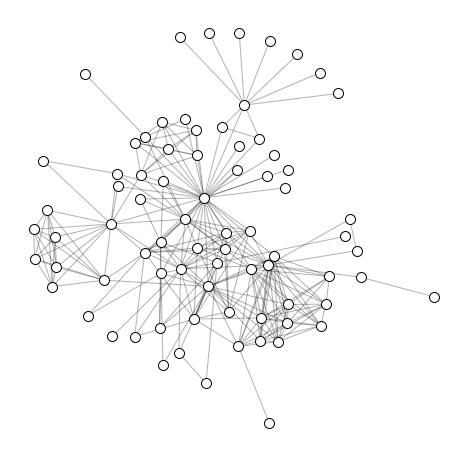

In [3]:
lesG = nx.Graph(nx.les_miserables_graph().edges)
lesG = nx.convert_node_labels_to_integers(lesG)
lespos = nx.kamada_kawai_layout(lesG)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(lesG, lespos, node_color='white', edgecolors='black', node_size=100)
nx.draw_networkx_edges(lesG, lespos, alpha=0.3)
plt.axis('off')
plt.show()

### Task 1. Agglomerative clustering (2 points)

Agglomerative clustering is an iterative procedure that unions similar clusters using a similarity matrix, but since we will run `sklearn.cluster.AgglomerativeClustering`, we need to pass a _distance_ matrix. So, first we need to choose a similarity measure and then convert it into a distance. Let us do it via SimRank measure that is defined as follows: _two objects are considered to be similar if they are referenced by similar objects_. Since SimRank takes values on the interval [0, 1], let us define a distance as

$$\text{Distance}= 1 - \text{SimRank}$$

Write a function `simrank_distance` that takes a graph and returns a distance matrix based on SimRank. Use `nx.simrank_similarity`. The distance matrix should be _absolutely_ symmetric.

In [4]:
def simrank_distance(G):
    s = nx.simrank_similarity_numpy(G) 
    res = np.around(1 - s, 3) 
    return res
    raise NotImplementedError()

In [5]:
distance = simrank_distance(lesG)
assert distance.shape == (77, 77)
assert np.diagonal(distance).sum() == 0
assert np.allclose(distance, distance.T, rtol=0, atol=0)
assert distance[52, 68] <= distance[1, 19]
assert distance[45, 29] <= distance[38, 46]

Then let us cluster nodes using `scipy.cluster.hierarchy.linkage`. The method takes distancies and returns a linkage matrix `Z` where every i-th row consists of
* `Z[i, 0]` and `Z[i, 1]` are indexes of combined clusters
* `Z[i, 2]` is the distance between combined clusters
* `Z[i, 3]` is the number of observations in combined clusters

Cluster with an index `n+i` is described in a i-th row of the matrix `Z`. Clusters with indexes less than `n+1` are initial nodes. The method `scipy.cluster.hierarchy.dendrogram` uses the matrix `Z` to plot a dendrogram. Let us look at a dendrogram of Les Miserables graph.

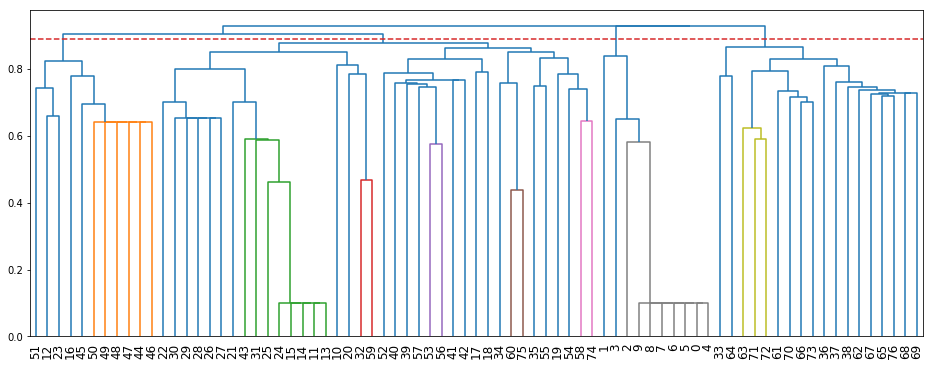

In [6]:
plt.figure(figsize=(16, 6))
linked = linkage(squareform(distance), 'complete')
dendrogram(linked, labels=list(lesG.nodes), 
           leaf_font_size=12)
plt.plot([0, 800], [0.89, 0.89], linestyle='--', c='tab:red')
plt.show()

Then we need to select a horizontal line that gives us a partitioning of the graph. There are two approaches: select the number of clusters, and select the maximal distance between clusters. For example, if we select a horicontal line with maximal distance 0.89 (a red line on the plot) then the number of clusters will be 4.

Write a function `agglomerative_clustering` that takes a distance matrix, maximal distance between clusters and returns an np.array with labels of clusters. Use `sklearn.cluster.AgglomerativeClustering` with complete linkage.

In [7]:
def agglomerative_clustering(distance, max_distance):
    agg=AgglomerativeClustering(n_clusters=None,affinity='precomputed',compute_full_tree=True,linkage='complete', distance_threshold=max_distance) 
    agg=agg.fit(distance)
    label = agg.labels_
    return label
    raise NotImplementedError()

In [8]:
assert len(set(agglomerative_clustering(distance, 0.8))) == 17
assert len(set(agglomerative_clustering(distance, 0.89))) == 4

On the graph with maximal distance 0.87

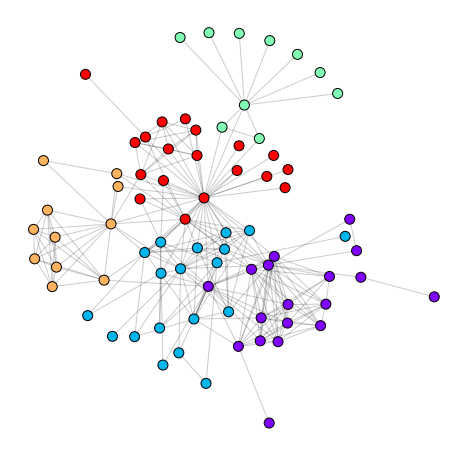

In [9]:
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    lesG, 
    lespos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    lesG,
    lespos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.show()

### Task 2. Louvain method (2 points)

Louvain method is one of the mostcited works in the community detection literature. It is a heuristic method based on modularity optimization for extracting the community structure of large networks. Let us consider this method on a ring of cliques.

In [10]:
def ring_of_cliques(csize, n):
    cliques = []
    for _ in range(n):
        cliques.append(nx.complete_graph(csize))
    G = nx.disjoint_union_all(cliques)
    for i in range(n):
        node_i = i * csize
        node_j = ((i + 1) * csize + 1) % (csize * n)
        G.add_edge(node_i, node_j)
    return G

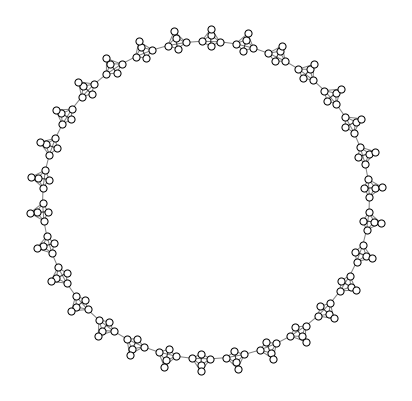

In [11]:
ringG = ring_of_cliques(csize=5, n=30)

plt.figure(figsize=(7, 7))
pos = nx.kamada_kawai_layout(ringG)
nx.draw_networkx_nodes(ringG, pos, node_color='white', 
                       edgecolors='black', node_size=50)
nx.draw_networkx_edges(ringG, pos, alpha=0.5)
plt.axis('off')
plt.show()

Let us compute expected number of edges for modularity calculation
$$e_{ij} = \frac{k_ik_j}{2m}$$
where $k_i$ is a degree of the node i and $m$ is the number of edges in a graph.

Write a function `expected_edges` that takes an adjacency matrix and number of edges `m` and returns a np.array with expected number of edges.

In [12]:
def expected_edges(A, m):

    raise NotImplementedError()

In [13]:
A = nx.to_numpy_array(ringG)
m = ringG.number_of_edges()
ee = expected_edges(A, m)
assert ee.shape == A.shape
assert np.all(0 <= ee)
assert round(ee[10, 10], 2) == round(ringG.degree[10] * ringG.degree[10] / 2 / m, 2)

NotImplementedError: 

Modularity helps to select a community that a node should belong to. Note that calculating the modularity costs $O(n^2)$, instead we can calculate *modularity gain* for $O(n)$. Consider community $c_\text{old}$ with a node $i$ and a community $c_\text{new}$ without a node $i$. The modularity gain is the change of modularity if we move a node $i$ from community $c_\text{old}$ into community $c_\text{new}$

$$\Delta M_i = \frac{1}{m}\left[ \sum_{j\in c_\text{new}} \left( A_{ij} - e_{ij} \right) - \sum_{j\in c_\text{old} \setminus \{i\}} \left( A_{ij} - e_{ij} \right) \right] $$

Write a function `modularity_gain` that takes an adjacency matrix `A`, expected edges `ee`, a moving node `mnode`, initial community `old_comm`, new community `new_comm` and number of edges `m`. It returns modularity gain. For simplicity, assume initial community does not contain a moving node.

In [14]:
def modularity_gain(A, ee, mnode, old_comm, new_comm, m):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
G = nx.complete_graph(6)
m1 = nx.algorithms.community.modularity(G, [[0, 1, 2], [3, 4, 5]])
m2 = nx.algorithms.community.modularity(G, [[0, 1], [2, 3, 4, 5]])
nx_gain = m2 - m1
nx_mod = nx.algorithms.community.modularity
del nx.algorithms.community.modularity
try:
    A = nx.to_numpy_array(G)
    m = G.number_of_edges()
    ee = expected_edges(A, m)
    gain = modularity_gain(A, ee, 2, [0, 1], [3, 4, 5], m)
except:
    raise AssertionError('networkx modularity usage')
finally:
    nx.algorithms.community.modularity = nx_mod
    del nx_mod
assert np.isclose(nx_gain, gain)

Louvain method

Phase 1: community unfolding
1. Put each node in its own community
2. For every node, calculate modularity gain and move it to the community with maximal modularity gain
3. Repeat until modularity stops increasing

Phase 2: network aggregation
1. Merge communities into ”super nodes”
2. Convert edges inside community into self loop, edges between communities into parallel edges

Repeat phases 1, 2 until modularity stops increasing.

In [ ]:
def louvain_method(G):
    
    # Phase 1: community unfolding
    communities = unfolded_communities(G)

    # Create labels
    labels = np.zeros(len(G))
    for i, c in enumerate(communities):
        labels[c] = i
    
    # Phase 2: network aggregation
    nextG = nx.empty_graph(len(communities), nx.MultiGraph)
    for e in G.edges:
        nextG.add_edge(labels[int(e[0])], labels[int(e[1])])
       
    return communities, labels, nextG

Write a function `unfolded_communities` that takes a graph, performs Phase 1 and returns list of communities with nodes. For example, if there are two communitites: the first is [1,2] and the second is [3,4,5] then the output will be [[1,2],[3,4,5]].

In [ ]:
def unfolded_communities(G):
    # Proposed template:
    A = nx.to_numpy_array(G)
    m = A.sum() / 2
    ee = expected_edges(A, m)
    communities = [[n] for n in G.nodes] # initial partition
    max_modularity_gain = 1
    while max_modularity_gain > 0:
        for node in G.nodes:
            '''
            1) Remove the node from the initial community.
            2) Iterate all neighboring communities and put a node 
               in the community with maximal modularity gain. If 
               there is no modularity gain, return the node into 
               the initial community.
            '''
            # YOUR CODE HERE
            raise NotImplementedError()
    return [c for c in communities if len(c)]

In [ ]:
ringG = ring_of_cliques(csize=5, n=30)
iterG = ringG.copy()
communities, labels, iterG = louvain_method(iterG)
assert len(set(labels)) == 30
assert len(set(labels[0:5])) == 1
assert len(set(labels[5:15])) == 2
assert iterG.number_of_nodes() == 30
for _ in range(2):
    communities, labels, iterG = louvain_method(iterG)
assert round(nx.algorithms.community.modularity(iterG, communities), 3) == 0.888

Let us see unfolding iterations. For every iteration we draw a graph where node color corresponds to the unfolded community.

In [ ]:
ringG = ring_of_cliques(csize=5, n=30)
iterG = ringG.copy()
plt.figure(figsize=(7, 8*3))
for i in range(3):
    plt.subplot(3, 1, i+1)
    communities, labels, nextG = louvain_method(iterG)
    # Shuffle label names for better visualization
    palette = np.unique(labels)
    key = np.random.permutation(palette)
    labels = key[np.digitize(labels, palette, right=True)]
    iter_pos = nx.kamada_kawai_layout(iterG)
    degree = np.array([d for n, d in iterG.degree])
    nodes = nx.draw_networkx_nodes(
        iterG,
        iter_pos,
        cmap=plt.cm.rainbow,
        node_color=labels,
        edgecolors='black',
        node_size=10*degree
    )
    _iterG = iterG.copy()
    _iterG.remove_edges_from(nx.selfloop_edges(iterG))
    nx.draw_networkx_edges(_iterG, iter_pos, alpha=0.5)
    plt.axis('off')
    plt.title(
        '{} nodes, {} communities \nModularity {:.3f}'.format(
            len(iterG), len(communities), nx.community.modularity(iterG, communities)))
    iterG = nextG

Communities in Les Miserables graph

In [ ]:
iterG = lesG.copy()
prev_comm, labels, iterG = louvain_method(iterG)
for i in range(2):
    next_comm, labels, iterG = louvain_method(iterG)
    communities = []
    for c in next_comm:
        temp = []
        for node in c:
            temp.extend(prev_comm[node])
        communities.append(temp)
    prev_comm = communities.copy()
labels = np.zeros(len(lesG))
for i, c in enumerate(communities):
    labels[c] = i

In [ ]:
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    lesG, 
    lespos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    edgecolors='black'
)
nx.draw_networkx_edges(lesG, lespos, alpha=0.3)
plt.title(
    '{} communities\nModularity {:.3f}'.format(
        len(communities), 
        nx.community.modularity(lesG, communities)
    )
)
plt.axis('off');

### Task 3. Label propogation  (3 points)

Among all the community detection techniques, label propagation is neither the most accurate nor the most robust method. It is, however, without doubt one of the simplest and fastest clustering methods. The label propagation method is based on the simple idea: every node is initialized with a unique label and at every step each node adopts the label that most of its neighbors currently have.

Write a function `update_labels` that takes a graph, np.array with labels in order `graph.nodes` and returns new labels. Label of the node is the random label occurring with the highest frequency among neighbors. At every iteration of label propagation, all nodes update their labels simultaneously (synchronous propagation).

In [ ]:
def sync_update_labels(graph, labels):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
nodes = set()
for _ in range(100):
    triadeG = nx.Graph([(0, 1), (0, 2)])
    labels = np.array(list(triadeG.nodes))
    labels = sync_update_labels(triadeG, labels)
    nodes = nodes.union(labels)
assert set([0, 1, 2]) == nodes # check randomness
labels = np.array(list(lesG.nodes)) # initial partition
new_labels = sync_update_labels(lesG, labels)
assert new_labels.shape == (77, )
assert len(set(new_labels)) < len(set(labels))
for _ in range(30):
    new_labels = sync_update_labels(lesG, new_labels)
assert len(set(new_labels)) > 1
starG = nx.star_graph(4)
labels = np.array(list(starG.nodes)) # initial partition
for _ in range(5):
    labels = sync_update_labels(starG, labels)
new_labels = sync_update_labels(starG, labels)
assert len(set(new_labels - labels)) == 2
assert np.sum(list(set(new_labels - labels))) == 0

In [ ]:
def plot_propagation(G, update_method, n=50):
    pos=nx.kamada_kawai_layout(G)
    labels = np.array(list(G.nodes))
    for i in range(n):
        clear_output(wait=True)
        labels = update_method(G, labels)
        plt.figure(figsize=(8, 8))
        nx.draw_networkx_nodes(
            G, 
            pos=pos, 
            node_color=labels, 
            cmap=plt.cm.rainbow,
            node_size=100, 
            edgecolors='black'
        )
        nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
        plt.axis('off')
        plt.title('Iteration {}/{}'.format(i+1, n))
        plt.show()

In [ ]:
plot_propagation(lesG, sync_update_labels, 30)

Notice that synchronous propagation can lead to oscillations of some labels in the network that are bi-partite or nearly bi-partite in structure. This is especially true in cases where communities take the form of a star graph.

In [ ]:
plot_propagation(nx.star_graph(30), sync_update_labels, 10)

For this reason, most label propagation algorithms implement asynchronous propagation. At every iteration of label propagation, the labels of the nodes are no longer updated all together, but sequentially in some random order, which is different for each iteration. This is in contrast to synchronous propagation, which always considers the labels from the previous iteration. Due to random order of label updates, asynchronous propagation successfully breaks the cyclic oscillations of labels.

Write a function `async_update_labels` that makes asynchronous label updating. The order in which all the n nodes in the network are updated is chosen randomly at each iteration.

In [ ]:
def async_update_labels(graph, labels):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
labels = np.array(list(lesG.nodes)) # initial partition
new_labels = async_update_labels(lesG, labels)
assert new_labels.shape == (77, )
assert len(set(new_labels)) < len(set(labels))
labels = np.array(list(starG.nodes)) # initial partition
for _ in range(5):
    labels = async_update_labels(starG, labels)
new_labels = async_update_labels(starG, labels)
assert np.all(new_labels - labels == 0)

In [ ]:
plot_propagation(nx.star_graph(30), async_update_labels, 10)

In [ ]:
plot_propagation(lesG, async_update_labels, 30)

### Task 4. Ego-Splitting (3 points)

Ego-Splitting is a framework for detecting clusters in complex networks which leverage the local structures known as ego-nets (i.e. the subgraph induced by the neighborhood of each node) to detect overlapping clusters. Ego-splittng is a highly scalable and flexible framework, with provable theoretical guarantees, that reduces the complex overlapping clustering problem to a simpler and more amenable non-overlapping (partitioning) problem.

Let us consider the algorithm on this small graph.

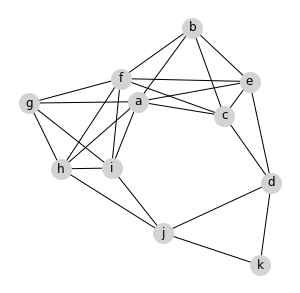

In [15]:
adjlist = [
    'a b c e h g i',
    'f b c e h g i',
    'b e c',
    'g i h',
    'e c d',
    'c d',
    'i h j',
    'h j',
    'j d k',
    'd k'
]
G = nx.parse_adjlist(adjlist)
plt.figure(figsize=(5, 5))
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx(
    G, pos, node_size=400, node_color='lightgray')
plt.axis('off');

The ego-splitting algorithm processes a graph and outputs a set of clusters as follows:
1. For each node we use the local clustering algorithm to partition the ego-net of the node.
2. Create a persona graph. Each node in the graph will correspond to $n$ "personas" (nodes in persona graph) where $n$ is a number of clusters in node's ego-net.
3. Apply the global clustering algorithm.

![](https://raw.githubusercontent.com/netspractice/network-science/main/images/ego_splitting.png)

In [16]:
def ego_splitting(graph):
    ego_nets = generate_ego_nets(graph)
    persona_graph = generate_persona_graph(ego_nets)
    return persona_clustering(personaG)

Write a function `generate_ego_nets` that takes a graph and returns a dictionary where keys are nodes and values are their ego-nets:

`{'a': ego-net of the node a, 'b': ego-net of the node b, ...}`

Ego-net *does not* include the ego-node.

*Hint: use `nx.ego_graph`*

In [17]:
def generate_ego_nets(graph):
    e = {}
    n = graph.nodes
    for node in n:
        e[node] = nx.ego_graph(graph, node, center=False)
    return e
    raise NotImplementedError()

In [18]:
ego_nets = generate_ego_nets(G)
assert set(ego_nets.keys()) == {'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'}
assert set(ego_nets['d'].nodes) == {'c', 'e', 'j', 'k'}
assert set(ego_nets['f'].nodes) == {'b', 'c', 'e', 'g', 'h', 'i'}

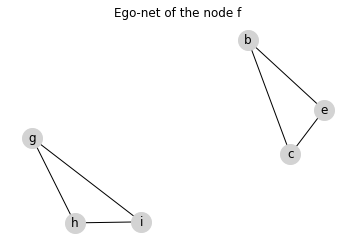

In [19]:
nx.draw_networkx(ego_nets['f'], pos=nx.kamada_kawai_layout(G), 
        node_color='lightgray', node_size=400)
plt.title('Ego-net of the node f')
plt.axis('off')
plt.show()

Next, we need to split each ego-net using any clustering method. Let it be the simple connected component detection method. 

In [20]:
def ego_clustering(graph):
    return [cc for cc in nx.connected_components(graph)]

Write a function `generate_persona_graph` that takes an ego-net dictionary and returns a persona graph:
1. Add a persona into each cluster in an ego-net and link it to each member. If there is more than one cluster then the persona name is the node name + cluster index. For example, if the ego-net `a` has two clusters `[b, c]` and `[d]` then we add peronas `a0, a1` and links `[a0, b]`, `[a0, c]`, `[a1, d]`.
2. Union all ego-nets into persona graph. 
3. Remove extra initial nodes that have personas. For example, if the persona graph has nodes `a`, `a0`, `a1`, then remove the node `a`.

In [ ]:
def generate_persona_graph(ego_nets):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
ego_nets = generate_ego_nets(G)
personaG = generate_persona_graph(ego_nets)
assert set(personaG.nodes) == {'i', 'f0', 'k', 'c', 'd0', 'a0', 'g', 'j0', 'e', 'h', 'd1', 'a1', 'j1', 'f1', 'b'}
assert {i[0] for i in personaG.neighbors('k')} == {'d', 'j'}
assert {i[0] for i in personaG.neighbors('g')} == {'a', 'f', 'h', 'i'}

In [ ]:
pos = nx.kamada_kawai_layout(G)
personapos = {}
for node in personaG.nodes:
    personapos[node] = pos[node[0]].copy()
    if len(node) > 1:
        personapos[node][0] += 0.05 if node[1] == '0' else -0.05
        personapos[node][1] += 0.05 if node[1] == '0' else -0.05
plt.figure(figsize=(5, 5))
nx.draw_networkx(personaG, personapos, node_size=300, node_color='lightgray')
plt.axis('off');

Finally, we need to apply any clustering algorithm for the persona graph. Let it again be the simple connected component detection algorithm. Also, here we remove the cluster indexes from node names.

In [ ]:
def persona_clustering(graph):
    communities = []
    for cc in nx.connected_components(graph):
        communities.append([node[0] for node in cc])
    return communities

In [ ]:
plt.figure(figsize=(15, 5))
pos = nx.kamada_kawai_layout(G)
c_colors = ['tab:orange', 'tab:blue', 'tab:green']
for i, c in enumerate(ego_splitting(G)):
    plt.subplot(1, 3, i+1)
    color = []
    for node in G.nodes:
        color.append(c_colors[i] if node in c else 'white')
    nx.draw_networkx(G, pos=pos, node_color=color, 
                     edgecolors='black', node_size=400)
    plt.axis('off')
    plt.title('Community {}'.format(i+1))